In [1]:
#Loading packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("pump_failure_dataset.csv")
df.head()

timestamp      value
0  2013-12-02 21:15:00  73.967322
1  2013-12-02 21:20:00  74.935882
2  2013-12-02 21:25:00  76.124162
3  2013-12-02 21:30:00  78.140707
4  2013-12-02 21:35:00  79.329836

In [3]:
#Searching for NaN values 
df.isna().sum()

timestamp    0
value        0
dtype: int64

In [4]:
df['timestamp'].dtype

dtype('O')

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

timestamp      value
0 2013-12-02 21:15:00  73.967322
1 2013-12-02 21:20:00  74.935882
2 2013-12-02 21:25:00  76.124162
3 2013-12-02 21:30:00  78.140707
4 2013-12-02 21:35:00  79.329836

In [6]:
df['timestamp'].dtype

dtype('<M8[ns]')

Text(0.5, 1.0, 'Gráfica')

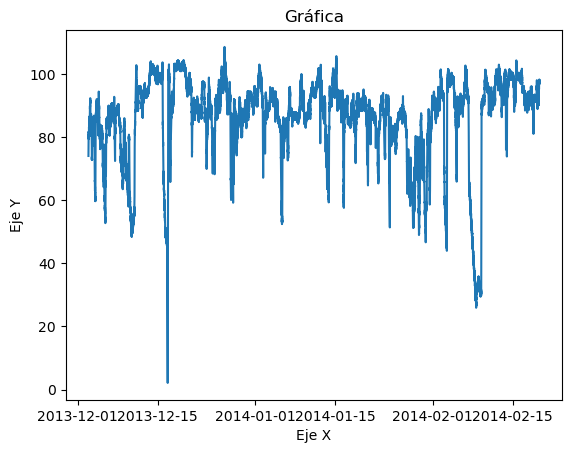

In [7]:
plt.plot(df['timestamp'], df['value'])
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

plt.title('Gráfica')

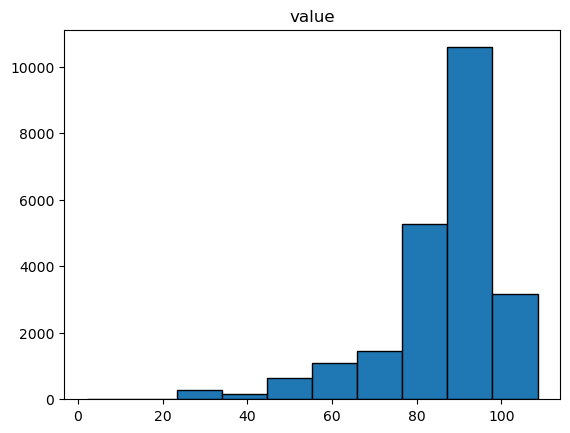

In [8]:
#A histogram is generated to better understand the data distribution and identify any outlier data points.
plt.title('value')
plt.hist(df['value'],edgecolor='black' ,linewidth=1)
plt.show()

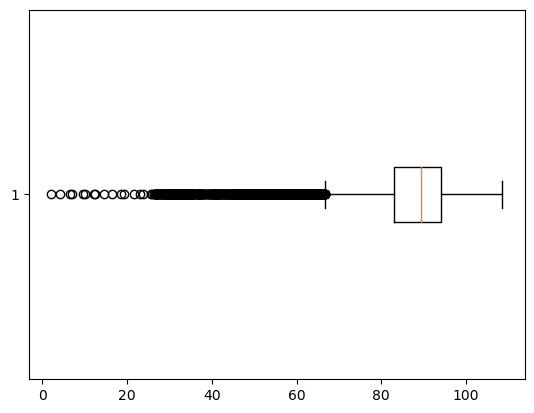

In [9]:
#We can observe in this boxplot how several data points are 'out of the norm' (outliers)
plt.boxplot(df['value'],vert=False)
plt.show()

In [10]:
#To ensure it doesn't impact us, we will perform the following 'Whisker' test
q1=df['value'].quantile(0.25)
print('Primer Cuartil', q1)

q3=df['value'].quantile(0.75)
print('Tercer Cuartil', q3)

IQR=q3-q1
print('Rango Intercuartil',IQR)

Mediana=df['value'].mean()
print('Mediana', Mediana)

Valor_min=df['value'].min()
print('Valor min', Valor_min)

Valor_max=df['value'].max()
print('Valor max', Valor_max)

Primer Cuartil 83.080077795
Tercer Cuartil 94.016251625
Rango Intercuartil 10.936173830000001
Mediana 85.92649821068021
Valor min 2.084721206
Valor max 108.5105428


In [11]:
bi_calculado=(q1-1.5*IQR)
print("bi_calculado \n", bi_calculado)

bs_calculado=(q1+1.5*IQR)
print("bi_calculado \n", bs_calculado)

bi_calculado 
 66.67581704999999
bi_calculado 
 99.48433854


In [12]:
#Outliers
outliers=(df['value']<bi_calculado) | (df['value']>bs_calculado)
outliers=df[outliers]
outliers

timestamp       value
320   2013-12-03 23:55:00   65.906496
321   2013-12-04 00:00:00   66.204651
322   2013-12-04 00:05:00   66.094398
323   2013-12-04 00:10:00   64.925151
324   2013-12-04 00:15:00   65.910542
...                   ...         ...
21816 2014-02-16 14:15:00   99.995663
21817 2014-02-16 14:20:00  100.093614
21818 2014-02-16 14:25:00  100.253086
21819 2014-02-16 14:30:00   99.678306
21824 2014-02-16 14:55:00   99.648964

[4209 rows x 2 columns]

In [13]:
#Data
sinoutliers=(df['value']>=bi_calculado) & (df['value']<=bs_calculado)
df2=df[sinoutliers]
df2

timestamp      value
0     2013-12-02 21:15:00  73.967322
1     2013-12-02 21:20:00  74.935882
2     2013-12-02 21:25:00  76.124162
3     2013-12-02 21:30:00  78.140707
4     2013-12-02 21:35:00  79.329836
...                   ...        ...
22690 2014-02-19 15:05:00  98.185415
22691 2014-02-19 15:10:00  97.804168
22692 2014-02-19 15:15:00  97.135468
22693 2014-02-19 15:20:00  98.056852
22694 2014-02-19 15:25:00  96.903861

[18486 rows x 2 columns]

In [14]:
duplicados = df2['timestamp'].duplicated()
filas_duplicadas = df2[duplicados]

print(filas_duplicadas) #They are not duplicates... both in Excel and Python, they show 12 duplicates (?)

                timestamp      value
10149 2014-01-07 02:00:00  94.139723
10150 2014-01-07 02:05:00  94.111970
10151 2014-01-07 02:10:00  94.638723
10152 2014-01-07 02:15:00  93.270907
10153 2014-01-07 02:20:00  93.890249
10154 2014-01-07 02:25:00  93.396627
10155 2014-01-07 02:30:00  94.199300
10156 2014-01-07 02:35:00  94.125420
10157 2014-01-07 02:40:00  93.530827
10158 2014-01-07 02:45:00  92.784720
10159 2014-01-07 02:50:00  93.254724
10160 2014-01-07 02:55:00  93.656042


In [15]:
#It was grouped to see if it would stop marking duplicates
df2= df2.groupby('timestamp')['value'].agg('mean').reset_index()
df2.head()

timestamp      value
0 2013-12-02 21:15:00  73.967322
1 2013-12-02 21:20:00  74.935882
2 2013-12-02 21:25:00  76.124162
3 2013-12-02 21:30:00  78.140707
4 2013-12-02 21:35:00  79.329836

In [16]:
df2.isna().sum()

timestamp    0
value        0
dtype: int64

In [17]:
df2 = pd.merge(df, df2, on='timestamp', how='left')
df2.head()

timestamp    value_x    value_y
0 2013-12-02 21:15:00  73.967322  73.967322
1 2013-12-02 21:20:00  74.935882  74.935882
2 2013-12-02 21:25:00  76.124162  76.124162
3 2013-12-02 21:30:00  78.140707  78.140707
4 2013-12-02 21:35:00  79.329836  79.329836

In [18]:
df2.tail()

timestamp    value_x    value_y
22690 2014-02-19 15:05:00  98.185415  98.185415
22691 2014-02-19 15:10:00  97.804168  97.804168
22692 2014-02-19 15:15:00  97.135468  97.135468
22693 2014-02-19 15:20:00  98.056852  98.056852
22694 2014-02-19 15:25:00  96.903861  96.903861

In [19]:
df.count()

timestamp    22695
value        22695
dtype: int64

In [20]:
df2.count()

timestamp    22695
value_x      22695
value_y      18486
dtype: int64

In [21]:
df2.isna().sum()

timestamp       0
value_x         0
value_y      4209
dtype: int64

In [22]:
del df2['value_x']
df2.rename(columns={'value_y': 'value'}, inplace=True)

In [23]:
df2.head()

timestamp      value
0 2013-12-02 21:15:00  73.967322
1 2013-12-02 21:20:00  74.935882
2 2013-12-02 21:25:00  76.124162
3 2013-12-02 21:30:00  78.140707
4 2013-12-02 21:35:00  79.329836

In [24]:
df2.isna().sum()

timestamp       0
value        4209
dtype: int64

In [25]:
duplicados = df2['timestamp'].dt.floor('s').duplicated()
filas_duplicadas = df2[duplicados]

print(filas_duplicadas)

                timestamp      value
10149 2014-01-07 02:00:00  94.281565
10150 2014-01-07 02:05:00  94.405350
10151 2014-01-07 02:10:00  94.985774
10152 2014-01-07 02:15:00  94.175053
10153 2014-01-07 02:20:00  94.385728
10154 2014-01-07 02:25:00  93.980294
10155 2014-01-07 02:30:00  93.815111
10156 2014-01-07 02:35:00  93.927542
10157 2014-01-07 02:40:00  93.361907
10158 2014-01-07 02:45:00  93.376296
10159 2014-01-07 02:50:00  93.326049
10160 2014-01-07 02:55:00  93.256020


In [26]:
df2.set_index('timestamp',inplace=True)
df2 = df2[~df2.index.duplicated(keep='first')]
#Empty values are filled
df2 = df2.reindex(df2.index).fillna(method="bfill")
df2=df2.asfreq("5T")
df2.head()

value
timestamp                     
2013-12-02 21:15:00  73.967322
2013-12-02 21:20:00  74.935882
2013-12-02 21:25:00  76.124162
2013-12-02 21:30:00  78.140707
2013-12-02 21:35:00  79.329836

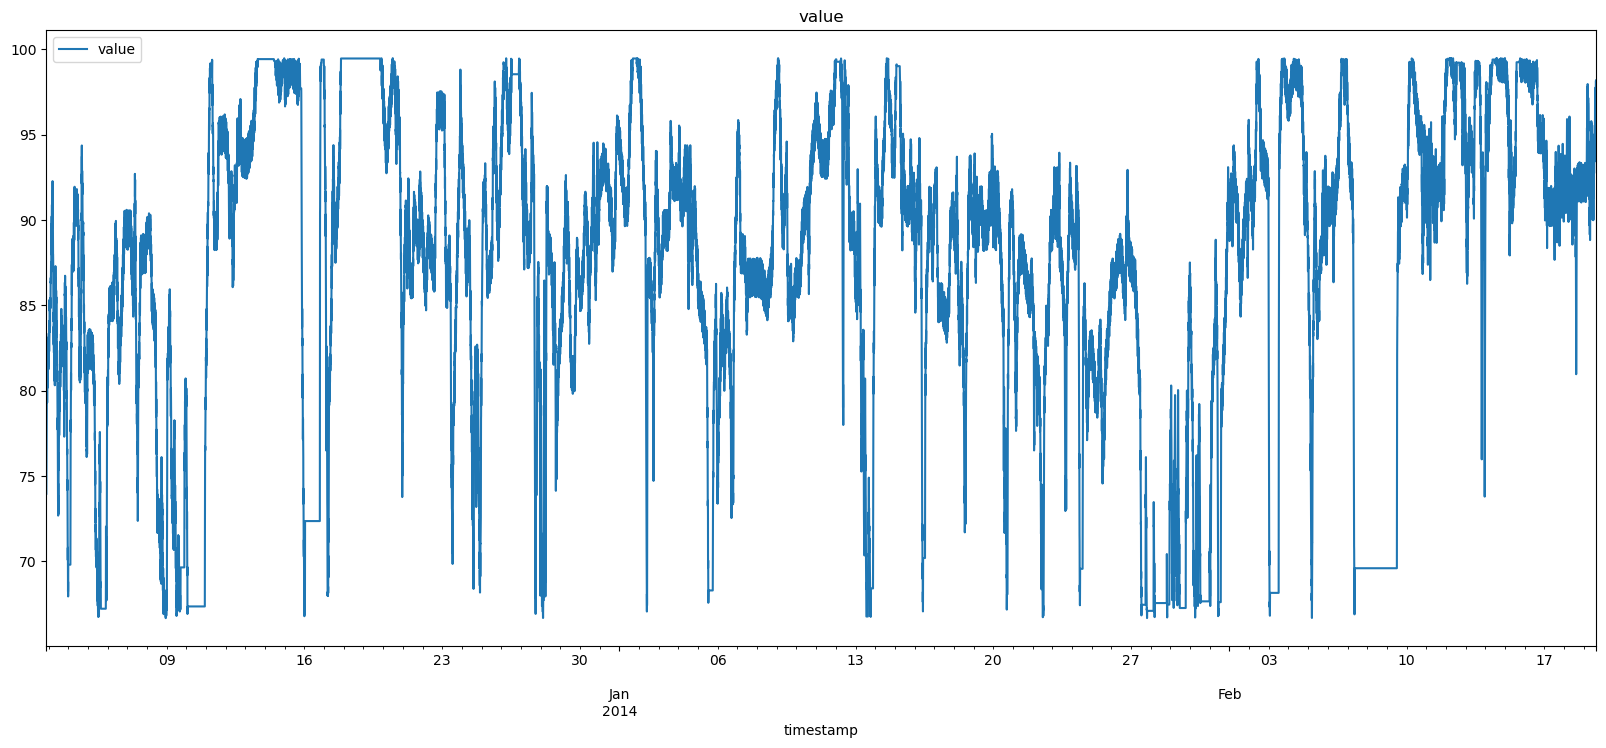

In [27]:
df2.plot(figsize=(20,8))
plt.title("value")
plt.show()

In [28]:
#Stationarity test
adf=adfuller(df2,maxlag=1)
print('El P-Value es:',adf[1])

El P-Value es: 2.2442481391843163e-06


In [29]:
#Data splitting, training, and testing
size=int(len(df2)*0.8)
df_train,df_test=df2[:size],df2[size:]
df_train.head()

value
timestamp                     
2013-12-02 21:15:00  73.967322
2013-12-02 21:20:00  74.935882
2013-12-02 21:25:00  76.124162
2013-12-02 21:30:00  78.140707
2013-12-02 21:35:00  79.329836

In [30]:
#AutoARIMA model (took around 2 minutes)
model_auto=auto_arima(df_train['value'])
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                18146
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -23526.182
Date:                Wed, 09 Aug 2023   AIC                          47068.364
Time:                        16:03:57   BIC                          47130.813
Sample:                    12-02-2013   HQIC                         47088.892
                         - 02-03-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1851      0.048     24.616      0.000       1.091       1.279
ar.L2         -0.1048      0.018     -5.775      0.000      -0.140      -0.069
ar.L3         -0.0488      0.014     -3.492      0.000      -0.076      -0.021
ar.L4         -0.0479      0.013     -3.707      0.000      -0.073      -0.023
ar.L5         -0.0565      0.011     -5.178      0.000      -0.078      -0.035
ma.L1         -1.5400      0.048    -32.065      0.000      -1.634      -1.446
ma.L2          0.6192      0.030     20.866      0.000       0.561       0.677
sigma2         0.7828      0.006    141.388      0.000       0.772       0.794
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12348.31
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
auto_pred=pd.DataFrame(model_auto.predict(70).rename('AutoArima'))

In [32]:
auto_pred

AutoArima
2014-02-03 21:25:00  97.576654
2014-02-03 21:30:00  97.459538
2014-02-03 21:35:00  97.345068
2014-02-03 21:40:00  97.238040
2014-02-03 21:45:00  97.200567
...                        ...
2014-02-04 02:50:00  96.972867
2014-02-04 02:55:00  96.972873
2014-02-04 03:00:00  96.972878
2014-02-04 03:05:00  96.972882
2014-02-04 03:10:00  96.972885

[70 rows x 1 columns]

In [33]:
model1=SARIMAX(df_train,order=(1,1,1),seasonal_order=(1,0,1,12))
results1=model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                18146
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood              -23912.151
Date:                            Wed, 09 Aug 2023   AIC                          47834.302
Time:                                    16:04:02   BIC                          47873.333
Sample:                                12-02-2013   HQIC                         47847.132
                                     - 02-03-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2554      0.018    -13.922      0.000      -0.291      -0.219
ma.L1         -0.0638      0.017     -3.701      0.000      -0.098      -0.030
ar.S.L12      -0.4135      0.243     -1.701      0.089      -0.890       0.063
ma.S.L12       0.4346      0.241      1.805      0.071      -0.037       0.906
sigma2         0.8169      0.006    138.121      0.000       0.805       0.828
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              9486.17
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
#obtain model data (adaptability)
predictionsSARIMAX = results1.predict(start=0, end=len(df_train)-1)

df_train['SARIMAX(1,1,1)(1,0,1,12)'] = predictionsSARIMAX.shift(-1)
df_train

value  SARIMAX(1,1,1)(1,0,1,12)
timestamp                                               
2013-12-02 21:15:00  73.967322                 73.967301
2013-12-02 21:20:00  74.935882                 74.632860
2013-12-02 21:25:00  76.124162                 75.725677
2013-12-02 21:30:00  78.140707                 77.471782
2013-12-02 21:35:00  79.329836                 78.907714
...                        ...                       ...
2014-02-03 21:00:00  98.963034                 98.429096
2014-02-03 21:05:00  98.750927                 98.802659
2014-02-03 21:10:00  98.053677                 98.277676
2014-02-03 21:15:00  98.740763                 98.536037
2014-02-03 21:20:00  96.882824                       NaN

[18146 rows x 2 columns]

In [35]:
#SMAPE test
def smape(y_true, y_pred):
    return (100 / len(y_true)) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [36]:
model11=SARIMAX(df_train['value'],order=(1,1,1),seasonal_order=(5,0,1,12))
results11=model11.fit()
results11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                18146
Model:             SARIMAX(1, 1, 1)x(5, 0, 1, 12)   Log Likelihood              -23901.882
Date:                            Wed, 09 Aug 2023   AIC                          47821.764
Time:                                    16:06:15   BIC                          47892.020
Sample:                                12-02-2013   HQIC                         47844.858
                                     - 02-03-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2545      0.018    -13.920      0.000      -0.290      -0.219
ma.L1         -0.0660      0.017     -3.846      0.000      -0.100      -0.032
ar.S.L12      -0.0720      0.269     -0.268      0.789      -0.599       0.455
ar.S.L24      -0.0090      0.009     -1.030      0.303      -0.026       0.008
ar.S.L36      -0.0011      0.008     -0.143      0.887      -0.016       0.014
ar.S.L48      -0.0209      0.007     -2.939      0.003      -0.035      -0.007
ar.S.L60      -0.0280      0.009     -3.200      0.001      -0.045      -0.011
ma.S.L12       0.0921      0.269      0.342      0.732      -0.435       0.619
sigma2         0.8160      0.006    137.793      0.000       0.804       0.828
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              9450.47
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
predictionsSARIMAX = results1.predict(start=0, end=len(df_train)-1)

df_train['SARIMAX(1,1,1)(5,0,1,12)'] = predictionsSARIMAX.shift(-1)
df_train

value  SARIMAX(1,1,1)(1,0,1,12)  \
timestamp                                                  
2013-12-02 21:15:00  73.967322                 73.967301   
2013-12-02 21:20:00  74.935882                 74.632860   
2013-12-02 21:25:00  76.124162                 75.725677   
2013-12-02 21:30:00  78.140707                 77.471782   
2013-12-02 21:35:00  79.329836                 78.907714   
...                        ...                       ...   
2014-02-03 21:00:00  98.963034                 98.429096   
2014-02-03 21:05:00  98.750927                 98.802659   
2014-02-03 21:10:00  98.053677                 98.277676   
2014-02-03 21:15:00  98.740763                 98.536037   
2014-02-03 21:20:00  96.882824                       NaN   

                     SARIMAX(1,1,1)(5,0,1,12)  
timestamp                                      
2013-12-02 21:15:00                 73.967301  
2013-12-02 21:20:00                 74.632860  
2013-12-02 21:25:00                 75.725677  
2013-12-02 21:30:00                 77.471782  
2013-12-02 21:35:00                 78.907714  
...                                       ...  
2014-02-03 21:00:00                 98.429096  
2014-02-03 21:05:00                 98.802659  
2014-02-03 21:10:00                 98.277676  
2014-02-03 21:15:00                 98.536037  
2014-02-03 21:20:00                       NaN  

[18146 rows x 3 columns]

In [38]:
model3=ARIMA(df_train['value'],order=(2,0,0))
result3=model3.fit()
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                18146
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -23914.014
Date:                Wed, 09 Aug 2023   AIC                          47836.028
Time:                        16:06:17   BIC                          47867.253
Sample:                    12-02-2013   HQIC                         47846.292
                         - 02-03-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         86.5517      1.779     48.645      0.000      83.064      90.039
ar.L1          0.6857      0.005    133.108      0.000       0.676       0.696
ar.L2          0.3106      0.005     60.881      0.000       0.301       0.321
sigma2         0.8168      0.006    132.905      0.000       0.805       0.829
===================================================================================
Ljung-Box (L1) (Q):                   1.80   Jarque-Bera (JB):              8281.68
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
predictions = result3.predict(start=0, end=len(df_train)-1)

df_train['ARIMA(2,0,0)'] = predictions.shift(-1)
df_train

value  SARIMAX(1,1,1)(1,0,1,12)  \
timestamp                                                  
2013-12-02 21:15:00  73.967322                 73.967301   
2013-12-02 21:20:00  74.935882                 74.632860   
2013-12-02 21:25:00  76.124162                 75.725677   
2013-12-02 21:30:00  78.140707                 77.471782   
2013-12-02 21:35:00  79.329836                 78.907714   
...                        ...                       ...   
2014-02-03 21:00:00  98.963034                 98.429096   
2014-02-03 21:05:00  98.750927                 98.802659   
2014-02-03 21:10:00  98.053677                 98.277676   
2014-02-03 21:15:00  98.740763                 98.536037   
2014-02-03 21:20:00  96.882824                       NaN   

                     SARIMAX(1,1,1)(5,0,1,12)  ARIMA(2,0,0)  
timestamp                                                    
2013-12-02 21:15:00                 73.967301     74.035707  
2013-12-02 21:20:00                 74.632860     74.678591  
2013-12-02 21:25:00                 75.725677     75.794179  
2013-12-02 21:30:00                 77.471782     77.545932  
2013-12-02 21:35:00                 78.907714     78.987580  
...                                       ...           ...  
2014-02-03 21:00:00                 98.429096     98.419739  
2014-02-03 21:05:00                 98.802659     98.771098  
2014-02-03 21:10:00                 98.277676     98.227133  
2014-02-03 21:15:00                 98.536037     98.481707  
2014-02-03 21:20:00                       NaN           NaN  

[18146 rows x 4 columns]

In [40]:
model4=ARIMA(df_train['value'],order=(2,1,1))
result4=model3.fit()
result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                18146
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -23914.014
Date:                Wed, 09 Aug 2023   AIC                          47836.028
Time:                        16:06:18   BIC                          47867.253
Sample:                    12-02-2013   HQIC                         47846.292
                         - 02-03-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         86.5517      1.779     48.645      0.000      83.064      90.039
ar.L1          0.6857      0.005    133.108      0.000       0.676       0.696
ar.L2          0.3106      0.005     60.881      0.000       0.301       0.321
sigma2         0.8168      0.006    132.905      0.000       0.805       0.829
===================================================================================
Ljung-Box (L1) (Q):                   1.80   Jarque-Bera (JB):              8281.68
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
predictions2 = result4.predict(start=0, end=len(df_train)-1)

df_train['ARIMA(2,1,0)'] = predictions2.shift(-1)
df_train

value  SARIMAX(1,1,1)(1,0,1,12)  \
timestamp                                                  
2013-12-02 21:15:00  73.967322                 73.967301   
2013-12-02 21:20:00  74.935882                 74.632860   
2013-12-02 21:25:00  76.124162                 75.725677   
2013-12-02 21:30:00  78.140707                 77.471782   
2013-12-02 21:35:00  79.329836                 78.907714   
...                        ...                       ...   
2014-02-03 21:00:00  98.963034                 98.429096   
2014-02-03 21:05:00  98.750927                 98.802659   
2014-02-03 21:10:00  98.053677                 98.277676   
2014-02-03 21:15:00  98.740763                 98.536037   
2014-02-03 21:20:00  96.882824                       NaN   

                     SARIMAX(1,1,1)(5,0,1,12)  ARIMA(2,0,0)  ARIMA(2,1,0)  
timestamp                                                                  
2013-12-02 21:15:00                 73.967301     74.035707     74.035707  
2013-12-02 21:20:00                 74.632860     74.678591     74.678591  
2013-12-02 21:25:00                 75.725677     75.794179     75.794179  
2013-12-02 21:30:00                 77.471782     77.545932     77.545932  
2013-12-02 21:35:00                 78.907714     78.987580     78.987580  
...                                       ...           ...           ...  
2014-02-03 21:00:00                 98.429096     98.419739     98.419739  
2014-02-03 21:05:00                 98.802659     98.771098     98.771098  
2014-02-03 21:10:00                 98.277676     98.227133     98.227133  
2014-02-03 21:15:00                 98.536037     98.481707     98.481707  
2014-02-03 21:20:00                       NaN           NaN           NaN  

[18146 rows x 5 columns]

In [42]:
model5=SimpleExpSmoothing(df_train['value']).fit(optimized=True)
df_train['SES']=model5.fittedvalues.shift(-1)
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       SimpleExpSmoothing Model Results                       
==============================================================================
Dep. Variable:                  value   No. Observations:                18146
Model:             SimpleExpSmoothing   SSE                          14987.825
Optimized:                       True   AIC                          -3465.732
Trend:                           None   BIC                          -3450.120
Seasonal:                        None   AICC                         -3465.730
Seasonal Periods:                None   Date:                 Wed, 09 Aug 2023
Box-Cox:                        False   Time:                         16:06:19
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.7243638                alpha                 True
initial_level              74.373446                  l.0                 True
------------------------------------------------------------------------------
"""

In [43]:
model6=ExponentialSmoothing(df_train['value'],trend='add').fit(optimized=True)
df_train['SEAd']=model6.fittedvalues.shift(-1)
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                    value   No. Observations:                18146
Model:             ExponentialSmoothing   SSE                          14920.207
Optimized:                         True   AIC                          -3543.783
Trend:                         Additive   BIC                          -3512.558
Seasonal:                          None   AICC                         -3543.778
Seasonal Periods:                  None   Date:                 Wed, 09 Aug 2023
Box-Cox:                          False   Time:                         16:06:19
Box-Cox Coeff.:                    None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.6520032                alpha                 True
smoothing_trend            0.1042639                 beta                 True
initial_level              73.815708                  l.0                 True
initial_trend              0.5247115                  b.0                 True
------------------------------------------------------------------------------
"""

In [44]:
model7=ExponentialSmoothing(df_train['value'],trend='mul').fit(optimized=True)
df_train['SEMul']=model7.fittedvalues.shift(-1)
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                    value   No. Observations:                18146
Model:             ExponentialSmoothing   SSE                          14936.969
Optimized:                         True   AIC                          -3523.409
Trend:                   Multiplicative   BIC                          -3492.185
Seasonal:                          None   AICC                         -3523.405
Seasonal Periods:                  None   Date:                 Wed, 09 Aug 2023
Box-Cox:                          False   Time:                         16:06:20
Box-Cox Coeff.:                    None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.6633570                alpha                 True
smoothing_trend            0.0883250                 beta                 True
initial_level              73.973463                  l.0                 True
initial_trend              1.0054815                  b.0                 True
------------------------------------------------------------------------------
"""

In [45]:
model8=ExponentialSmoothing(df_train['value'],trend='add', seasonal='add',seasonal_periods=12).fit()
df_train['SETAd']=model8.fittedvalues.shift(-1)

model9=ExponentialSmoothing(df_train['value'],trend='mul', seasonal='add',seasonal_periods=12).fit()
df_train['SETMul']=model9.fittedvalues.shift(-1)
df_train

value  SARIMAX(1,1,1)(1,0,1,12)  \
timestamp                                                  
2013-12-02 21:15:00  73.967322                 73.967301   
2013-12-02 21:20:00  74.935882                 74.632860   
2013-12-02 21:25:00  76.124162                 75.725677   
2013-12-02 21:30:00  78.140707                 77.471782   
2013-12-02 21:35:00  79.329836                 78.907714   
...                        ...                       ...   
2014-02-03 21:00:00  98.963034                 98.429096   
2014-02-03 21:05:00  98.750927                 98.802659   
2014-02-03 21:10:00  98.053677                 98.277676   
2014-02-03 21:15:00  98.740763                 98.536037   
2014-02-03 21:20:00  96.882824                       NaN   

                     SARIMAX(1,1,1)(5,0,1,12)  ARIMA(2,0,0)  ARIMA(2,1,0)  \
timestamp                                                                   
2013-12-02 21:15:00                 73.967301     74.035707     74.035707   
2013-12-02 21:20:00                 74.632860     74.678591     74.678591   
2013-12-02 21:25:00                 75.725677     75.794179     75.794179   
2013-12-02 21:30:00                 77.471782     77.545932     77.545932   
2013-12-02 21:35:00                 78.907714     78.987580     78.987580   
...                                       ...           ...           ...   
2014-02-03 21:00:00                 98.429096     98.419739     98.419739   
2014-02-03 21:05:00                 98.802659     98.771098     98.771098   
2014-02-03 21:10:00                 98.277676     98.227133     98.227133   
2014-02-03 21:15:00                 98.536037     98.481707     98.481707   
2014-02-03 21:20:00                       NaN           NaN           NaN   

                           SES       SEAd      SEMul      SETAd     SETMul  
timestamp                                                                   
2013-12-02 21:15:00  74.079265  74.596507  74.487948  74.580929  74.567127  
2013-12-02 21:20:00  74.699767  75.340200  75.197129  75.360819  75.338463  
2013-12-02 21:25:00  75.731547  76.427059  76.284843  76.438339  76.415024  
2013-12-02 21:30:00  77.476656  78.236571  78.110511  78.220707  78.201162  
2013-12-02 21:35:00  78.819032  79.715911  79.597425  79.714340  79.695974  
...                        ...        ...        ...        ...        ...  
2014-02-03 21:00:00  98.517080  98.418121  98.428329  98.395674  98.397893  
2014-02-03 21:05:00  98.686470  98.707985  98.700217  98.689126  98.687598  
2014-02-03 21:10:00  98.228098  98.309767  98.291264  98.312966  98.308414  
2014-02-03 21:15:00  98.599454  98.648471  98.635863  98.632733  98.629970  
2014-02-03 21:20:00        NaN        NaN        NaN        NaN        NaN  

[18146 rows x 10 columns]

In [46]:
SMAPE_SARIMAX1=smape(df_train['value'],df_train['SARIMAX(1,1,1)(1,0,1,12)'] )
SMAPE_SARIMAX2=smape(df_train['value'],df_train['SARIMAX(1,1,1)(5,0,1,12)'] )
ARIMA1=smape(df_train['value'],df_train['ARIMA(2,0,0)'] )
ARIMA2=smape(df_train['value'],df_train['ARIMA(2,1,0)'] )
SE1=smape(df_train['value'],df_train['SES'] )
SE2=smape(df_train['value'],df_train['SEAd'] )
SE3=smape(df_train['value'],df_train['SEMul'] )
SE4=smape(df_train['value'],df_train['SETAd'] )
SE5=smape(df_train['value'],df_train['SETMul'] )
print(f'SMAPE_SARIMAX1: {SMAPE_SARIMAX1:.2f}%')
print(f'SMAPE_SARIMAX2: {SMAPE_SARIMAX2:.2f}%')
print(f'SMAPE ARIMA1: {ARIMA1:.2f}%')
print(f'SMAPE ARIMA2: {ARIMA2:.2f}%')
print(f'SMAPE SE1: {SE1:.2f}%')
print(f'SMAPE SE2: {SE2:.2f}%')
print(f'SMAPE SE3: {SE3:.2f}%')
print(f'SMAPE SE4: {SE4:.2f}%')
print(f'SMAPE SE5: {SE5:.2f}%')

SMAPE_SARIMAX1: 0.25%
SMAPE_SARIMAX2: 0.25%
SMAPE ARIMA1: 0.27%
SMAPE ARIMA2: 0.27%
SMAPE SE1: 0.21%
SMAPE SE2: 0.29%
SMAPE SE3: 0.28%
SMAPE SE4: 0.30%
SMAPE SE5: 0.29%


In [47]:
# Prediction
steps=len(df_test)
predictions = model5.forecast(steps=steps)
predictions

2014-02-03 21:25:00    97.35599
2014-02-03 21:30:00    97.35599
2014-02-03 21:35:00    97.35599
2014-02-03 21:40:00    97.35599
2014-02-03 21:45:00    97.35599
                         ...   
2014-02-19 15:05:00    97.35599
2014-02-19 15:10:00    97.35599
2014-02-19 15:15:00    97.35599
2014-02-19 15:20:00    97.35599
2014-02-19 15:25:00    97.35599
Freq: 5T, Length: 4537, dtype: float64

In [48]:
#The prediction did not turn out as expected

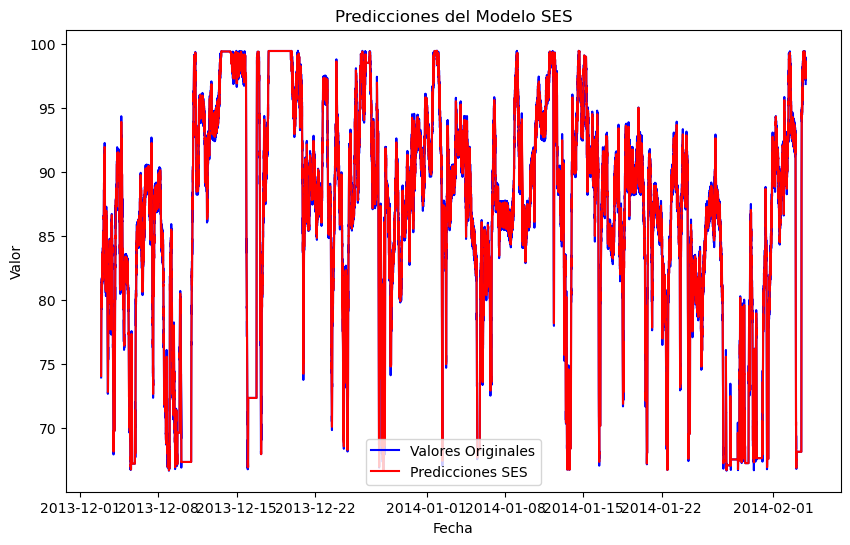

In [49]:
# Training data plot
plt.figure(figsize=(10, 6))
plt.plot(df_train.index, df_train['value'], label='Valores Originales', color='blue')
plt.plot(df_train.index, df_train['SES'], label='Predicciones SES', color='red')

plt.title('Predicciones del Modelo SES')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

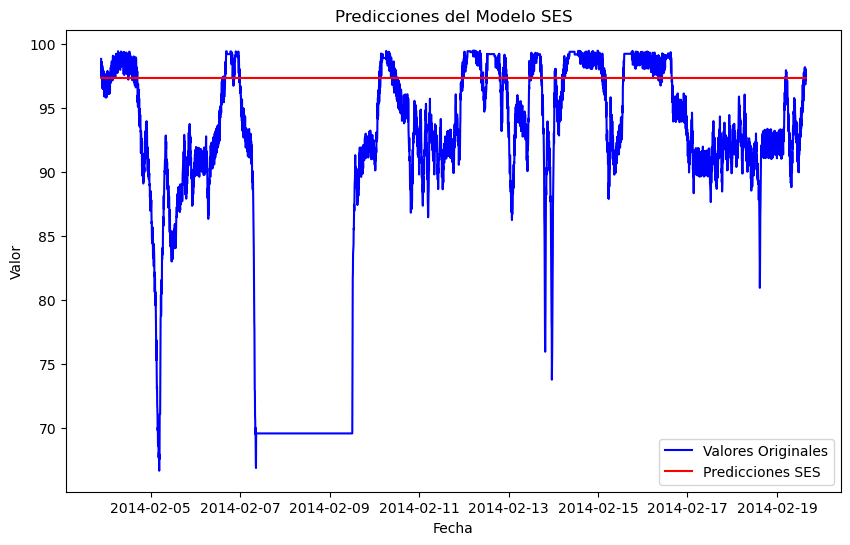

In [50]:
# Test data plot
plt.figure(figsize=(10, 6))
plt.plot(df_test.index, df_test['value'], label='Valores Originales', color='blue')
plt.plot(df_test.index, predictions, label='Predicciones SES', color='red')

plt.title('Predicciones del Modelo SES')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [51]:
import seaborn as sns
import xgboost as xgb

In [52]:
df2

value
timestamp                     
2013-12-02 21:15:00  73.967322
2013-12-02 21:20:00  74.935882
2013-12-02 21:25:00  76.124162
2013-12-02 21:30:00  78.140707
2013-12-02 21:35:00  79.329836
...                        ...
2014-02-19 15:05:00  98.185415
2014-02-19 15:10:00  97.804168
2014-02-19 15:15:00  97.135468
2014-02-19 15:20:00  98.056852
2014-02-19 15:25:00  96.903861

[22683 rows x 1 columns]

In [53]:
df_test.count()

value    4537
dtype: int64

In [54]:
def create_features(df2):
    df2['hour']=df2.index.hour
    df2['minute']=df2.index.minute
    df2['dayofweek']=df2.index.dayofweek
    df2['quarter']=df2.index.quarter
    df2['month']=df2.index.month
    df2['year']=df2.index.year
    return df2

In [55]:
df2=create_features(df2)

In [56]:
size=int(len(df2)*0.8)
df_train,df_test=df2[:size],df2[size:]
df_train.head()

value  hour  minute  dayofweek  quarter  month  year
timestamp                                                                    
2013-12-02 21:15:00  73.967322    21      15          0        4     12  2013
2013-12-02 21:20:00  74.935882    21      20          0        4     12  2013
2013-12-02 21:25:00  76.124162    21      25          0        4     12  2013
2013-12-02 21:30:00  78.140707    21      30          0        4     12  2013
2013-12-02 21:35:00  79.329836    21      35          0        4     12  2013

In [57]:
train=create_features(df_train)
test=create_features(df_test)

In [58]:
feature =['hour','minute','dayofweek','quarter','month','year']
target = 'value'

In [59]:
x_train=train[feature]
y_train=train[target]

x_test=test[feature]
y_test=test[target]

In [60]:
df2.count()

value        22683
hour         22683
minute       22683
dayofweek    22683
quarter      22683
month        22683
year         22683
dtype: int64

In [61]:
reg=xgb.XGBRegressor(n_estimators=1000,learning_rate=0.01)
reg.fit(x_train,y_train,
       eval_set=[(x_train, y_train),(x_test,y_test)],
       verbose=100)

[0]	validation_0-rmse:85.67956	validation_1-rmse:89.70566
[100]	validation_0-rmse:32.29002	validation_1-rmse:35.56500
[200]	validation_0-rmse:13.96876	validation_1-rmse:17.31910
[300]	validation_0-rmse:8.94812	validation_1-rmse:12.94672
[400]	validation_0-rmse:8.00713	validation_1-rmse:12.29928
[500]	validation_0-rmse:7.85135	validation_1-rmse:12.32974
[600]	validation_0-rmse:7.82181	validation_1-rmse:12.38339
[700]	validation_0-rmse:7.81202	validation_1-rmse:12.43283
[800]	validation_0-rmse:7.80676	validation_1-rmse:12.46769
[900]	validation_0-rmse:7.80187	validation_1-rmse:12.50820
[999]	validation_0-rmse:7.79877	validation_1-rmse:12.53128


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [62]:
predictions = reg.predict(x_test)
df_test['predictions'] = predictions
df_test

value  hour  minute  dayofweek  quarter  month  year  \
timestamp                                                                       
2014-02-03 21:25:00  98.841761    21      25          0        1      2  2014   
2014-02-03 21:30:00  97.474381    21      30          0        1      2  2014   
2014-02-03 21:35:00  97.492345    21      35          0        1      2  2014   
2014-02-03 21:40:00  98.622080    21      40          0        1      2  2014   
2014-02-03 21:45:00  97.845144    21      45          0        1      2  2014   
...                        ...   ...     ...        ...      ...    ...   ...   
2014-02-19 15:05:00  98.185415    15       5          2        1      2  2014   
2014-02-19 15:10:00  97.804168    15      10          2        1      2  2014   
2014-02-19 15:15:00  97.135468    15      15          2        1      2  2014   
2014-02-19 15:20:00  98.056852    15      20          2        1      2  2014   
2014-02-19 15:25:00  96.903861    15      25          2        1      2  2014   

                     predictions  
timestamp                         
2014-02-03 21:25:00    98.073311  
2014-02-03 21:30:00    98.508789  
2014-02-03 21:35:00    98.748199  
2014-02-03 21:40:00    98.727646  
2014-02-03 21:45:00    98.779030  
...                          ...  
2014-02-19 15:05:00    91.431259  
2014-02-19 15:10:00    91.442406  
2014-02-19 15:15:00    91.438644  
2014-02-19 15:20:00    91.437820  
2014-02-19 15:25:00    91.535133  

[4537 rows x 8 columns]

In [63]:
xgb=smape(df_test['value'],df_test['predictions'] )
print(f'SMAPE XGB: {xgb:.2f}%')

SMAPE XGB: 11.19%


In [64]:
del df_test['hour']
del df_test['minute']
del df_test['dayofweek']
del df_test['quarter']
del df_test['month']
del df_test['year']
del df_train['hour']
del df_train['minute']
del df_train['dayofweek']
del df_train['quarter']
del df_train['month']
del df_train['year']
del df2['hour']
del df2['minute']
del df2['dayofweek']
del df2['quarter']
del df2['month']
del df2['year']

In [65]:
df_test

value  predictions
timestamp                                  
2014-02-03 21:25:00  98.841761    98.073311
2014-02-03 21:30:00  97.474381    98.508789
2014-02-03 21:35:00  97.492345    98.748199
2014-02-03 21:40:00  98.622080    98.727646
2014-02-03 21:45:00  97.845144    98.779030
...                        ...          ...
2014-02-19 15:05:00  98.185415    91.431259
2014-02-19 15:10:00  97.804168    91.442406
2014-02-19 15:15:00  97.135468    91.438644
2014-02-19 15:20:00  98.056852    91.437820
2014-02-19 15:25:00  96.903861    91.535133

[4537 rows x 2 columns]

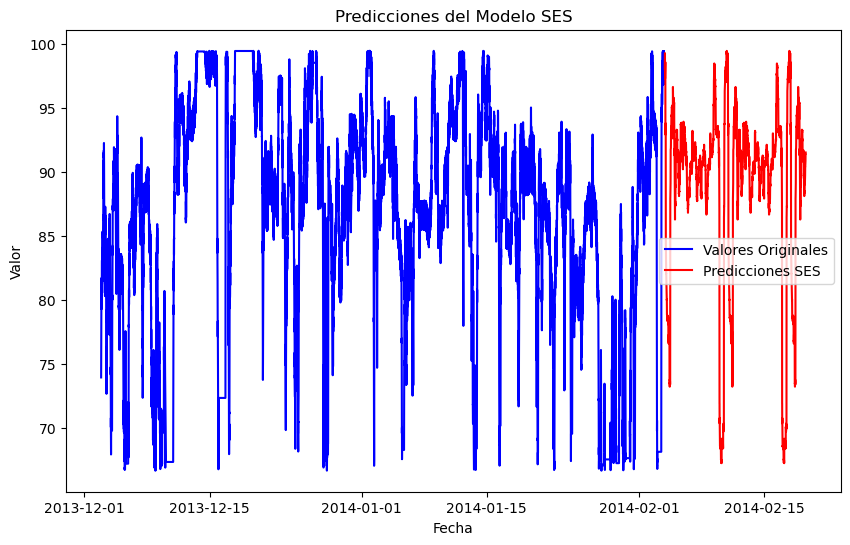

In [66]:
# Plotting the original values and predictions
plt.figure(figsize=(10, 6))
plt.plot(df_train.index, df_train['value'], label='Valores Originales', color='blue')
plt.plot(df_test.index, df_test['predictions'], label='Predicciones SES', color='red')

plt.title('Predicciones del Modelo SES')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [67]:
from pycaret.time_series import *
from typing_extensions import final

In [68]:
df_train

value
timestamp                     
2013-12-02 21:15:00  73.967322
2013-12-02 21:20:00  74.935882
2013-12-02 21:25:00  76.124162
2013-12-02 21:30:00  78.140707
2013-12-02 21:35:00  79.329836
...                        ...
2014-02-03 21:00:00  98.963034
2014-02-03 21:05:00  98.750927
2014-02-03 21:10:00  98.053677
2014-02-03 21:15:00  98.740763
2014-02-03 21:20:00  96.882824

[18146 rows x 1 columns]

In [69]:
df2 = df2[~df2.index.duplicated(keep='first')]
df2

value
timestamp                     
2013-12-02 21:15:00  73.967322
2013-12-02 21:20:00  74.935882
2013-12-02 21:25:00  76.124162
2013-12-02 21:30:00  78.140707
2013-12-02 21:35:00  79.329836
...                        ...
2014-02-19 15:05:00  98.185415
2014-02-19 15:10:00  97.804168
2014-02-19 15:15:00  97.135468
2014-02-19 15:20:00  98.056852
2014-02-19 15:25:00  96.903861

[22683 rows x 1 columns]

In [70]:
# Setting up the environment
model_setup = setup(data=df_train,fh=1000, fold_strategy='sliding', session_id=123)

In [71]:
# Comparing and training models
mix_model = compare_models(n_select=2)

Processing:   0%|          | 0/118 [00:00<?, ?it/s]

In [72]:
blend=blend_models(mix_model)

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [73]:
final_model=finalize_model(blend)

In [74]:
plot_model(final_model,plot='forecast')

In [75]:
predictionpycaret=pd.DataFrame(predict_model(final_model))
predictionpycaret

y_pred
2014-02-03 21:25  96.8066
2014-02-03 21:30  96.6258
2014-02-03 21:35  96.6100
2014-02-03 21:40  96.5754
2014-02-03 21:45  96.5491
...                   ...
2014-02-07 08:20  93.3910
2014-02-07 08:25  93.3957
2014-02-07 08:30  93.3819
2014-02-07 08:35  93.3834
2014-02-07 08:40  93.3882

[1000 rows x 1 columns]

In [76]:
predictionpycaret.index.rename('timestamp', inplace=True)
predictionpycaret.index = predictionpycaret.index.strftime('%Y-%m-%d %H:%M:00')
predictionpycaret

y_pred
timestamp                   
2014-02-03 21:25:00  96.8066
2014-02-03 21:30:00  96.6258
2014-02-03 21:35:00  96.6100
2014-02-03 21:40:00  96.5754
2014-02-03 21:45:00  96.5491
...                      ...
2014-02-07 08:20:00  93.3910
2014-02-07 08:25:00  93.3957
2014-02-07 08:30:00  93.3819
2014-02-07 08:35:00  93.3834
2014-02-07 08:40:00  93.3882

[1000 rows x 1 columns]

In [77]:
predictionpycaret.index.dtype

dtype('O')

In [78]:
predictionpycaret['timestamp'] = pd.to_datetime(predictionpycaret.index)
predictionpycaret

y_pred           timestamp
timestamp                                       
2014-02-03 21:25:00  96.8066 2014-02-03 21:25:00
2014-02-03 21:30:00  96.6258 2014-02-03 21:30:00
2014-02-03 21:35:00  96.6100 2014-02-03 21:35:00
2014-02-03 21:40:00  96.5754 2014-02-03 21:40:00
2014-02-03 21:45:00  96.5491 2014-02-03 21:45:00
...                      ...                 ...
2014-02-07 08:20:00  93.3910 2014-02-07 08:20:00
2014-02-07 08:25:00  93.3957 2014-02-07 08:25:00
2014-02-07 08:30:00  93.3819 2014-02-07 08:30:00
2014-02-07 08:35:00  93.3834 2014-02-07 08:35:00
2014-02-07 08:40:00  93.3882 2014-02-07 08:40:00

[1000 rows x 2 columns]

In [79]:
predictionpycaret['timestamp'].dtype

dtype('<M8[ns]')

In [80]:
predictionpycaret= predictionpycaret.reset_index(drop=True)
predictionpycaret

y_pred           timestamp
0    96.8066 2014-02-03 21:25:00
1    96.6258 2014-02-03 21:30:00
2    96.6100 2014-02-03 21:35:00
3    96.5754 2014-02-03 21:40:00
4    96.5491 2014-02-03 21:45:00
..       ...                 ...
995  93.3910 2014-02-07 08:20:00
996  93.3957 2014-02-07 08:25:00
997  93.3819 2014-02-07 08:30:00
998  93.3834 2014-02-07 08:35:00
999  93.3882 2014-02-07 08:40:00

[1000 rows x 2 columns]

In [81]:
predictionpycaret.set_index('timestamp',inplace=True)
predictionpycaret

y_pred
timestamp                   
2014-02-03 21:25:00  96.8066
2014-02-03 21:30:00  96.6258
2014-02-03 21:35:00  96.6100
2014-02-03 21:40:00  96.5754
2014-02-03 21:45:00  96.5491
...                      ...
2014-02-07 08:20:00  93.3910
2014-02-07 08:25:00  93.3957
2014-02-07 08:30:00  93.3819
2014-02-07 08:35:00  93.3834
2014-02-07 08:40:00  93.3882

[1000 rows x 1 columns]

In [82]:
df_test.index.dtype

dtype('<M8[ns]')

In [83]:
df2 = pd.merge(df_test,predictionpycaret , on='timestamp', how='inner')
df2.head()

value  predictions   y_pred
timestamp                                           
2014-02-03 21:25:00  98.841761    98.073311  96.8066
2014-02-03 21:30:00  97.474381    98.508789  96.6258
2014-02-03 21:35:00  97.492345    98.748199  96.6100
2014-02-03 21:40:00  98.622080    98.727646  96.5754
2014-02-03 21:45:00  97.845144    98.779030  96.5491

In [84]:
pycaret=smape(df2['value'],df2['y_pred'] )
xgb=smape(df2['value'],df2['predictions'] )
print(f'SMAPE XGB: {xgb:.2f}%')
print(f'SMAPE PYCARET: {pycaret:.2f}%')

SMAPE XGB: 7.91%
SMAPE PYCARET: 5.45%


In [85]:
#An attempt was made with another model to perform the forecast; however, we see that they do not fit well
predictionsSARIMAX = results11.forecast(45)
predicted_values = predictionsSARIMAX
predicted_values

2014-02-03 21:25:00    97.461787
2014-02-03 21:30:00    97.323981
2014-02-03 21:35:00    97.366008
2014-02-03 21:40:00    97.339324
2014-02-03 21:45:00    97.335307
2014-02-03 21:50:00    97.326254
2014-02-03 21:55:00    97.330501
2014-02-03 22:00:00    97.379197
2014-02-03 22:05:00    97.374740
2014-02-03 22:10:00    97.356288
2014-02-03 22:15:00    97.374090
2014-02-03 22:20:00    97.328272
2014-02-03 22:25:00    97.339833
2014-02-03 22:30:00    97.348373
2014-02-03 22:35:00    97.344876
2014-02-03 22:40:00    97.358816
2014-02-03 22:45:00    97.369855
2014-02-03 22:50:00    97.363223
2014-02-03 22:55:00    97.365981
2014-02-03 23:00:00    97.353229
2014-02-03 23:05:00    97.333066
2014-02-03 23:10:00    97.363653
2014-02-03 23:15:00    97.356600
2014-02-03 23:20:00    97.363928
2014-02-03 23:25:00    97.357906
2014-02-03 23:30:00    97.383797
2014-02-03 23:35:00    97.374676
2014-02-03 23:40:00    97.375718
2014-02-03 23:45:00    97.398009
2014-02-03 23:50:00    97.381102
2014-02-03

In [86]:
predictionsSARIMAX = results1.forecast(45)
predicted_values = predictionsSARIMAX
predicted_values

2014-02-03 21:25:00    97.463208
2014-02-03 21:30:00    97.322473
2014-02-03 21:35:00    97.364496
2014-02-03 21:40:00    97.348727
2014-02-03 21:45:00    97.338200
2014-02-03 21:50:00    97.330191
2014-02-03 21:55:00    97.331794
2014-02-03 22:00:00    97.380994
2014-02-03 22:05:00    97.380705
2014-02-03 22:10:00    97.357065
2014-02-03 22:15:00    97.374626
2014-02-03 22:20:00    97.334533
2014-02-03 22:25:00    97.346776
2014-02-03 22:30:00    97.340559
2014-02-03 22:35:00    97.339631
2014-02-03 22:40:00    97.341951
2014-02-03 22:45:00    97.347377
2014-02-03 22:50:00    97.350415
2014-02-03 22:55:00    97.349822
2014-02-03 23:00:00    97.329458
2014-02-03 23:05:00    97.329582
2014-02-03 23:10:00    97.339357
2014-02-03 23:15:00    97.332095
2014-02-03 23:20:00    97.348675
2014-02-03 23:25:00    97.343612
2014-02-03 23:30:00    97.346183
2014-02-03 23:35:00    97.346567
2014-02-03 23:40:00    97.345607
2014-02-03 23:45:00    97.343364
2014-02-03 23:50:00    97.342107
2014-02-03

In [87]:
predictionsARIMA = result3.forecast(50)
predicted_values = predictionsARIMA
predicted_values

2014-02-03 21:25:00    97.421147
2014-02-03 21:30:00    97.213236
2014-02-03 21:35:00    97.237865
2014-02-03 21:40:00    97.190181
2014-02-03 21:45:00    97.165134
2014-02-03 21:50:00    97.133150
2014-02-03 21:55:00    97.103441
2014-02-03 22:00:00    97.073137
2014-02-03 22:05:00    97.043131
2014-02-03 22:10:00    97.013144
2014-02-03 22:15:00    96.983264
2014-02-03 22:20:00    96.953463
2014-02-03 22:25:00    96.923749
2014-02-03 22:30:00    96.894119
2014-02-03 22:35:00    96.864574
2014-02-03 22:40:00    96.835114
2014-02-03 22:45:00    96.805737
2014-02-03 22:50:00    96.776445
2014-02-03 22:55:00    96.747236
2014-02-03 23:00:00    96.718111
2014-02-03 23:05:00    96.689068
2014-02-03 23:10:00    96.660109
2014-02-03 23:15:00    96.631233
2014-02-03 23:20:00    96.602439
2014-02-03 23:25:00    96.573727
2014-02-03 23:30:00    96.545097
2014-02-03 23:35:00    96.516549
2014-02-03 23:40:00    96.488083
2014-02-03 23:45:00    96.459698
2014-02-03 23:50:00    96.431394
2014-02-03

In [88]:
#Conclusion 
#Apparently, PyCaret had better fit, however, this is only in the first 1000 data points since 
#If we increase the forecast to around 4530 (approx), which is the quantity contained in the test data, PyCaret stops making predictions
#And it sends constant values, whereas XGBoost adapts better to predict more future data
#The others, where predictions couldn't be made since the values were constant or simply decreasing until reaching 0
#which indicates that the models didn't adapt.